This is a simple ipynb File to check the working of model on the dataset.


In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder  # For preprocessing input data
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
data = pd.read_csv(r'C:/Users/Mock_Data.csv')

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   transaction_id           1000 non-null   int64 
 1   transaction_date         1000 non-null   object
 2   transaction_amount       1000 non-null   int64 
 3   merchant_category        1000 non-null   object
 4   card_type                1000 non-null   object
 5   transaction_location     1000 non-null   object
 6   cardholder_age           1000 non-null   int64 
 7   cardholder_gender        1000 non-null   object
 8   transaction_description  1000 non-null   object
 9   account_balance          1000 non-null   int64 
 10  calander_income          1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [71]:
# Define columns to be scaled, excluding 'transaction_id'
data = data.drop('transaction_id', axis=1)
    
#Convert to datetime format
data['transaction_date'] = pd.to_datetime(data['transaction_date'],format='%d-%m-%Y')

# Extract components
data['transaction_year'] = data['transaction_date'].dt.year
data['transaction_month'] = data['transaction_date'].dt.month
data['transaction_day'] = data['transaction_date'].dt.day

# Drop the transaction_date column
data = data.drop('transaction_date', axis=1)



numerical_cols = [
    'transaction_amount', 'cardholder_age', 'account_balance', 'calander_income','transaction_year','transaction_month','transaction_day'
]

categorical_cols = [
    'merchant_category', 'card_type', 'transaction_location', 'cardholder_gender', 'transaction_description'
]

# Create a temporary DataFrame for scaling
temp_data = data[numerical_cols].copy()
temp_data.columns = temp_data.columns.str.strip()
print(temp_data.head())

scaler = StandardScaler() # Initialize the StandardScaler
temp_data = pd.DataFrame(scaler.fit_transform(temp_data), columns=numerical_cols) # Scale numerical columns

# Encode categorical columns
encoder = LabelEncoder() # Initialize the LabelEncoder
for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col]) # Encode categorical columns

# Rejoin scaled numerical columns
data = data.drop(columns=numerical_cols) # Drop original numerical columns
data = pd.concat([data, temp_data], axis=1) # Concatenate scaled numerical columns back

   transaction_amount  cardholder_age  account_balance  calander_income  \
0                7277               9            31454           159045   
1                8919              65            96536            50525   
2                8023              57            21820           148395   
3                 392               7              543            72023   
4                8347              71             5872            53364   

   transaction_year  transaction_month  transaction_day  
0              2024                  4               23  
1              2022                  7               11  
2              2022                 12               22  
3              2022                  7               21  
4              2024                  4               30  


In [72]:
data.head()

,merchant_category,card_type,transaction_location,cardholder_gender,transaction_description,transaction_amount,cardholder_age,account_balance,calander_income,transaction_year,transaction_month,transaction_day
0,3,0,1,2,129,0.743856,-1.403021,-0.754383,0.967126,1.439195,-0.639109,0.853088
1,6,0,7,1,291,1.306674,0.505341,1.534423,-1.156623,-0.444568,0.236383,-0.502095
2,7,3,7,0,404,0.999558,0.232718,-1.093191,0.758704,-0.444568,1.695536,0.740156
3,7,1,6,0,19,-1.616071,-1.471177,-1.841461,-0.735905,-0.444568,0.236383,0.627224
4,1,1,9,2,122,1.110613,0.709808,-1.654051,-1.101064,1.439195,-0.639109,1.643612


In [73]:
# Print each column name and its type
data.columns = data.columns.astype('str')
for col in data.columns:
#     print(f"Column name: {col}, Type: {type(col)}")
    if not isinstance(col, str):  # Check if the column name is not a string
        print(col)
        

In [74]:
#Check for any NaN or Infinite values
print(np.any(np.isnan(data)))
print(np.any(np.isinf(data)))

False

In [75]:
from sklearn.model_selection import train_test_split
X = data
X_train, X_temp = train_test_split(X, test_size=0.4, random_state=42)  # 60% train, 40% temp
X_test, X_temp = train_test_split(X_temp, test_size=0.625, random_state=42)  # 0.25 * 0.4 = 0.45 for test
X_val, X_superval= train_test_split(X_temp, test_size=0.5, random_state=42)

In [76]:
# X_train = X_train.values
# X_test = X_test.values

In [77]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, silhouette_score
def perform_hyperparameter_tuning(X_train):
    # Define the grid of hyperparameters to search over
    param_grid = {
        'n_estimators': [100, 50, 70],  # Number of base estimators in ensemble
        'max_samples': [0.1, 0.05, 0.75],  # Maximum number of samples to draw from the dataset
        'max_features':[0.05,0.5,0.7], #Number of Features to draw from dataset to train each base estimator
        'contamination': [0.01, 0.05, 0.02],  # Proportion of outliers in the sample
        'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    }
    
    # Initialize an IsolationForest Ensemble
    model = IsolationForest(random_state=42)
 
     # Use a custom scorer, for example, negative mean squared error
    def scorer(estimator, X):
        cluster_labels = estimator.fit_predict(X)
        return silhouette_score(X,cluster_labels)
    # scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # Initialize a GridSearchCV to search for the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2,scoring=scorer)
    
    # Fit the GridSearchCV to the training data
    grid_search.fit(X_train)
    
    # Retrieve the best model with the optimal hyperparameters
    best_model = grid_search.best_estimator_
    
    # Print the best hyperparameters found
    print("Best hyperparameters:", grid_search.best_params_)
    
    # Return the best model
    return best_model, grid_search.best_params_

In [78]:
best_model, best_params = perform_hyperparameter_tuning(X_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best hyperparameters: {'bootstrap': True, 'contamination': 0.05, 'max_features': 0.7, 'max_samples': 0.75, 'n_estimators': 50}


In [79]:
best_model.fit(X_train)

IsolationForest(bootstrap=True, contamination=0.05, max_features=0.7,
                max_samples=0.75, n_estimators=50, random_state=42)

In [80]:
pred = best_model.predict(X_test)

In [81]:
print("Unique labels in pred:", set(pred))

Unique labels in pred: {1, -1}


In [82]:
def preprocess_input_data(transaction_date, transaction_amount, merchant_category, card_type, transaction_location,
                          cardholder_age, cardholder_gender, transaction_description, account_balance, calander_income):
    # Prepare input data as a DataFrame
    data = pd.DataFrame({
        'transaction_date': [transaction_date],  # transaction_date
        'merchant_category': [merchant_category],  # merchant_category
        'card_type': [card_type],  # card_type
        'transaction_location': [transaction_location],  # transaction_location
        'cardholder_gender': [cardholder_gender],  # cardholder_gender
        'transaction_amount': [transaction_amount],  # transaction_amount
        'cardholder_age': [cardholder_age],  # cardholder_age
        'account_balance': [account_balance],  # account_balance
        'calander_income': [calander_income],  # calander_income
        'transaction_description': [transaction_description],  # transaction_description
    })
    # Handle date columns
    data['transaction_date'] = pd.to_datetime(data['transaction_date'],format='%d-%m-%Y')  # Convert signup date to datetime
    
    # Extract features from date columns
    data['transaction_year'] = data['transaction_date'].dt.year  # Extract year from transaction date
    data['transaction_month'] = data['transaction_date'].dt.month  # Extract month from transaction date
    data['transaction_day'] = data['transaction_date'].dt.day  # Extract day from transaction date
    
    # Drop original date columns
    data = data.drop(columns=['transaction_date'])

    numerical_cols = [
        'transaction_amount', 'cardholder_age', 'account_balance', 'calander_income','transaction_year','transaction_month','transaction_day'
    ]

    categorical_cols = [
        'merchant_category', 'card_type', 'transaction_location', 'cardholder_gender', 'transaction_description'
    ]

    # Create a temporary DataFrame for scaling
    temp_data = data[numerical_cols].copy()
    temp_data.columns = temp_data.columns.str.strip()

    scaler = StandardScaler() # Initialize the StandardScaler
    temp_data = pd.DataFrame(scaler.fit_transform(temp_data)) # Scale numerical columns
    # Encode categorical columns
    encoder = LabelEncoder() # Initialize the LabelEncoder
    for col in categorical_cols:
        data[col] = encoder.fit_transform(data[col]) # Encode categorical columns

    # Rejoin scaled numerical columns
    data = data.drop(columns=numerical_cols) # Drop original numerical columns
    data = pd.concat([data, temp_data], axis=1) # Concatenate scaled numerical columns back

    return data

def predict_output(transaction_date, transaction_amount, merchant_category, card_type, transaction_location,
                          cardholder_age, cardholder_gender, transaction_description, account_balance, calander_income):
    
    # Preprocess input data
    data = preprocess_input_data(transaction_date, transaction_amount, merchant_category, card_type, transaction_location,
                          cardholder_age, cardholder_gender, transaction_description, account_balance, calander_income)
    print(data.head())
    
    
    # Predict output
    try:
        prediction = best_model.predict(data.values)  # Make a prediction (assume only one prediction is made)
        return f"Model Prediction: {prediction}"  # Return the prediction
    except Exception as e:
        print("Error during prediction:", e)  # Print any error that occurs
        return None


In [83]:
predict_output('30-06-2023',2625.20,'Restaurant','Amex','Bengaluru',25,'Female','Nunc purus',4992,22497)

   merchant_category  card_type  transaction_location  cardholder_gender  \
0                  0          0                     0                  0   

   transaction_description    0    1    2    3    4    5    6  
0                        0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  


'Model Prediction: [1]'

In [84]:
pred_val = best_model.predict(X_val)
print("Unique labels in pred:", set(pred_val))

Unique labels in pred: {1, -1}


c:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [85]:
pred_superval = best_model.predict(X_superval)
print("Unique labels in pred:", set(pred_superval))

Unique labels in pred: {1, -1}


c:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [86]:
from sklearn.metrics import davies_bouldin_score
test_db_index = davies_bouldin_score(X_test, pred)
test_sh_index = silhouette_score(X_test,pred)
val_sh_index = silhouette_score(X_val,pred_val)
superval_sh_index = silhouette_score(X_superval,pred_superval)

In [16]:
print(test_db_index)

4.452983544397346


In [17]:
print(test_sh_index)

0.28939692910960135


In [ ]:
print(val_sh_index)

In [ ]:
print(superval_sh_index)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

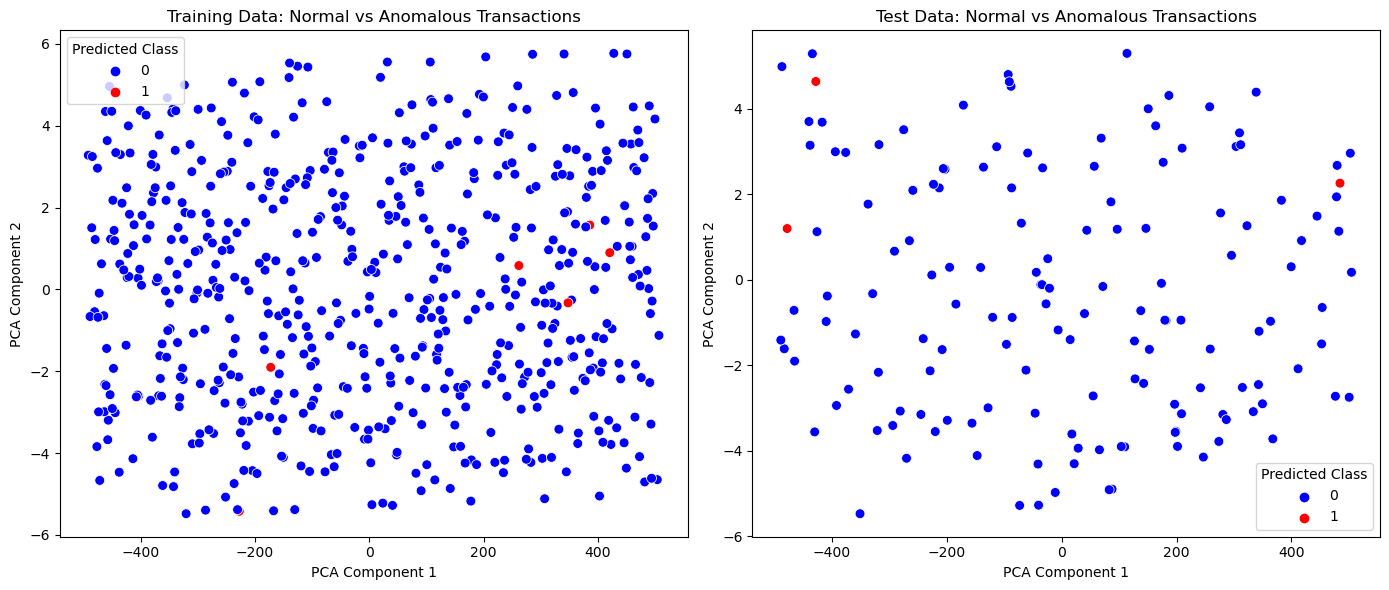

In [19]:
best_model.fit(X_train)

# Predict on training and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Convert predictions to numerical values for plotting
y_train_pred_numerical = np.where(y_train_pred == -1, 1, 0)
y_test_pred_numerical = np.where(y_test_pred == -1, 1, 0)

# Create DataFrames for plotting
train_data = pd.DataFrame({
    'Feature 1': X_train_reduced[:, 0],
    'Feature 2': X_train_reduced[:, 1],
    'predicted_class': y_train_pred_numerical
})

test_data = pd.DataFrame({
    'Feature 1': X_test_reduced[:, 0],
    'Feature 2': X_test_reduced[:, 1],
    'predicted_class': y_test_pred_numerical
})

# Plot training data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Feature 1', y='Feature 2', hue='predicted_class', data=train_data,
                palette={0: 'blue', 1: 'red'}, s=50)
plt.title('Training Data: Normal vs Anomalous Transactions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Predicted Class', loc='best')

# Plot test data
plt.subplot(1, 2, 2)
sns.scatterplot(x='Feature 1', y='Feature 2', hue='predicted_class', data=test_data,
                palette={0: 'blue', 1: 'red'}, s=50)
plt.title('Test Data: Normal vs Anomalous Transactions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Predicted Class', loc='best')

plt.tight_layout()
plt.show()

In [1]:
from pymongo import MongoClient # For connecting to MongoDB database
import pickle # For loading the model from a pickle file
client = MongoClient(host='localhost', port=27017)
db = client["1"]
collection = db['x_train']
document = collection.find_one()
print(document)  # Check if document exists and what fields it has

{'_id': ObjectId('66ec52770efff6bd7030c8d9'), 'data': b'\x80\x04\x95]\xc9\x00\x00\x00\x00\x00\x00\x8c\x11pandas.core.frame\x94\x8c\tDataFrame\x94\x93\x94)\x81\x94}\x94(\x8c\x04_mgr\x94\x8c\x1epandas.core.internals.managers\x94\x8c\x0cBlockManager\x94\x93\x94(\x8c\x16pandas._libs.internals\x94\x8c\x0f_unpickle_block\x94\x93\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x01MX\x02\x86\x94h\x0f\x8c\x05dtype\x94\x93\x94\x8c\x02i4\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B`\t\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00\x04\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x05\x00\x00\x00\x03\x00\x00\x00\x02\x00\x00\x00\x06\x00\x00\x00\x03\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x00\x04\x00\x00\x00\x

In [2]:
if document:
    print(document.keys())

dict_keys(['_id', 'data'])
